<a href="https://colab.research.google.com/github/ucheokechukwu/ml_tensorflow_deeplearning/blob/main/08_introduction_to_nlp_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# introduction to NLP fundamentals in Tensorflow

NLP has the goal of deriving information out of natural langauge (could be sequence text or speech).

Another common term for NLP problems is sequence to sequence problmes (seq2seq).

In [1]:
## check for GPU
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
# get helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-03-07 23:08:28--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-07 23:08:28 (58.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset
Kaggle's introduction to NLP dataset. Text samples of tweets labelled as disaster or not disaster. 
- binary clssification
https://www.kaggle.com/c/nlp-getting-started

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
unzip_data("nlp_getting_started.zip")


--2023-03-07 23:08:39--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.162.128, 74.125.31.128, 172.253.123.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.162.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.02s   

2023-03-07 23:08:39 (31.3 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

to visualize our text samples, we first have to read them in. we can do so using Pandas for Python 

In [4]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df["text"][20]

'this is ridiculous....'

In [6]:
train_df_shuffled = train_df.sample(frac=1, random_state=42)

In [7]:
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [8]:
# what does the text dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
# how many examples of each class are there?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [10]:
# how many total samples
len(train_df), len(test_df)

(7613, 3263)

In [11]:
# let's visualize some random training examples
import random
random_index = random.randint(0,len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
@Kiwi_Karyn Check out what's in my parking lot!! He said that until last year it was an ambulance in St Johns. http://t.co/hPvOdUD7iP

---

Target: 1 (real disaster)
Text:
@DarrellIssa Does that 'great Iran deal' cover bioterrorism? You got cut off terrible of them. Keep up the good work.

---

Target: 0 (not real disaster)
Text:
Life is amazin same time its crazy niggas dey wanna blaze me hate it because i made it all it took was dedication n some motivation

---

Target: 0 (not real disaster)
Text:
Check Out: 'Reddit Will Now Quarantine Offensive Content' http://t.co/Ew5wZC07Fo

---

Target: 1 (real disaster)
Text:
I feel like if MKayla and Cee ever got in the same room everyone should evacuate because it would be so petty and childish I couldn't deal

---



### Split data into training and validation sets

In [12]:
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                             train_df_shuffled["target"].to_numpy(),
                                                                             test_size=0.1,
                                                                             random_state=42)
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [13]:
# Check the first ten examples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

When dealing with text problem, one of the first things you need to do is numerically encode the text.

Methods:

1. Tokenization - direct mapping of token (word or character to number) or one-hot encoding.

2 - Embedding - creating a matrix of feature vectors for each token. The size of the vector can be defined and this embedding, which is essentially a matrix of weights can be learned.

## Text vectorization (tokenization)

In [14]:
import tensorflow as tf
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import TextVectorization

In [15]:
# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None,
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None,
                                    output_mode="int",
                                    output_sequence_length=None
                                    )

In [16]:
# find the average number of tokens (words) in the training tweets

In [17]:
len(train_sentences[0].split())


7

In [18]:

round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [19]:
# set up text vectorization variables
max_vocab_length = 10000 #max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

# fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [20]:
sample_sentence="there is a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 74,   9,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,
          0,   0]])>

* Note that the shape is (1,15) because we passed it in **1** sequence and **15** is because the max_length is 15.

In [21]:
text_vectorizer(["there is a man in my backyard!"])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  74,    9,    3,   89,    4,   13, 6143,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [22]:
random_sentence = random.choice(train_sentences)
print(f"Original text: \n{random_sentence}\n\n\nVectorized Version: {text_vectorizer([random_sentence])}")

Original text: 
?#FUKUSHIMA?#TEPCO?
Mountains of debris from the Japanese tsunami have floated to the West Coast
http://t.co/y518jYrZav


Vectorized Version: [[5593 2854    6  247   20    2 1128  525   24 3840    5    2  695 1148
     1]]


In [23]:
# get the unique words in the vocubalary
words_in_vocab = text_vectorizer.get_vocabulary() # get all the unique words in our training data
top_5_words = words_in_vocab[:10]
bottom_5_words = words_in_vocab[-10:]
print(f"Number of words in vocab: {len(words_in_vocab)} \n\n5 most common words: \n{top_5_words}\n\n5 least common words: \n{bottom_5_words}")
# [UNK] is unknown text, that is it's outside of 10000 words

Number of words in vocab: 10000 

5 most common words: 
['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is']

5 least common words: 
['painthey', 'painful', 'paine', 'paging', 'pageshi', 'pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


## Text vectorization (embedding)
`tf.keras.layers.Embedding`
turns positive integers into dense vectors of fixed size
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:
* `input_dim` - the size of our vocabulary
* `output_dim` - the size of the output embedding vector e.g. a value of 100 means each token gets represented by a vector of length 100
* `input_length` - the length of sequences passed into the embedding layer (in this case, it's 15)

In [24]:
from tensorflow.keras import layers
embedding = layers.Embedding(input_dim=max_vocab_length, #set input shape
                             output_dim=128, #neural networks work best with numbers divisible by 8
                             input_length=max_length # how long is each input
)

In [25]:
# test on random sentences from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text: \n{random_sentence}\
n\nEmbedded version:")
# embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer(random_sentence))
sample_embed

Original text: 
11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...n
Embedded version:


<tf.Tensor: shape=(15, 128), dtype=float32, numpy=
array([[ 0.01372606,  0.01601252, -0.04875722, ...,  0.03273237,
        -0.02703474, -0.02764205],
       [-0.04028105,  0.02520302,  0.01210886, ...,  0.0468947 ,
         0.04278277, -0.03962444],
       [ 0.03933788,  0.04081296, -0.00312225, ...,  0.02013595,
        -0.02164987, -0.04747006],
       ...,
       [-0.04935816, -0.02642803,  0.03225962, ...,  0.04249886,
         0.04865536,  0.04626094],
       [ 0.03933788,  0.04081296, -0.00312225, ...,  0.02013595,
        -0.02164987, -0.04747006],
       [ 0.03179044,  0.02734045,  0.00533632, ...,  0.04963285,
         0.00144862,  0.02081302]], dtype=float32)>

In [26]:
sample_embed = tf.expand_dims(sample_embed, axis=0)

In [27]:
# check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 1.37260593e-02,  1.60125159e-02, -4.87572215e-02,  1.71391703e-02,
         1.24416836e-02, -4.52968143e-02,  1.59036033e-02, -1.49968974e-02,
         4.61827181e-02,  4.63757999e-02,  3.52636687e-02, -2.60646939e-02,
         4.86554615e-02,  1.50332116e-02,  2.64605023e-02, -1.55714899e-03,
         4.11393531e-02,  2.09144689e-02,  1.25272013e-02, -2.08045729e-02,
        -3.29644904e-02, -2.94854492e-03, -1.59287453e-03,  4.36604358e-02,
         3.51761617e-02, -5.02414629e-03,  6.68443739e-04,  2.36427076e-02,
        -9.49390233e-05,  2.60942057e-03, -3.20880786e-02, -9.83270258e-03,
         1.10462904e-02,  8.95297527e-03,  6.04356453e-03, -4.51201089e-02,
         2.16581933e-02, -4.40696627e-03,  7.11109489e-03,  1.56673454e-02,
         1.15814209e-02,  3.81952263e-02, -3.72626297e-02,  8.85264948e-03,
         2.88957097e-02,  1.74731500e-02, -4.44634929e-02,  1.54619105e-02,
        -4.74314690e-02,  8.95074755e-0

# Modelling our text dataset - running a series of experiments

It's time to start building a series of modelling experiments, starting with a baseline and moving on from there:

* Model 0: Naive Bayes (baseline)
* Model 1: feed-forward neural network (dense model)
* Model 2: LSTM model (long-short term memory) (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional LSTM model (RNN)
* Model 5: 1D Convolutional Neural network
* Model 6: Tensorflow Hub pretrained feature extracctor (using transfer learning for NLP)
* Model 7: same as 6 with 10% of the dataset

Method of approach: standard steps with modelling with tensorflow:
- prepare data -> build -> compile -> fit -> evaluate -> experiment and improve

## Model 0 - getting a baseline
This will be our baseline model that serves as a benchmark for future experiments to build up. We're going to use `sklearn` Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers. 

* 🔑 It's common practice to use non-DL algorithm as a baseline because of their speed and later use DL to see how to improve upon them.

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


In [29]:
# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
    ("clf", MultinomialNB()) # model the text using this classifier(clf)
])

# fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [30]:
# evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels) 
#.score is for sklearn what .evaluate is for tensorflow. the default evaluation metric for classification is accuracy

In [31]:
print(f"Our baseline score achieves an accuracy of {baseline_score*100:.2f}%")

Our baseline score achieves an accuracy of 79.27%


In [32]:
# make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [33]:
# Creating evaluation function
def evaluation (model, val_sentences, val_labels):
  """Function to return the evaluation metrics of a model 
  given the model and the validation data
  """
  from sklearn.metrics import recall_score, precision_score, classification_report
  accuracy = model.score(val_sentences, val_labels)
  predicted_labels = model.predict(val_sentences)
  precision = precision_score(val_labels, predicted_labels)
  recall = recall_score(val_labels, predicted_labels)
  report = classification_report(val_labels, predicted_labels)

  return accuracy, precision, recall, report

In [34]:
base_evaluation = evaluation(model_0, val_sentences, val_labels)
print(f"Accuracy is: {base_evaluation[0]*100:.2f}%. \nPrecision Score is:{base_evaluation[1]:.2f}\
\nRecall Score is: {base_evaluation[2]:.2f} \
\n\n\nClassification Report is {base_evaluation[3]}")

Accuracy is: 79.27%. 
Precision Score is:0.89
Recall Score is: 0.63 


Classification Report is               precision    recall  f1-score   support

           0       0.75      0.93      0.83       414
           1       0.89      0.63      0.73       348

    accuracy                           0.79       762
   macro avg       0.82      0.78      0.78       762
weighted avg       0.81      0.79      0.79       762



In [35]:
# Creating evaluation function
def calculate_results (y_true, y_preds):
  """Function to return the evaluation metrics of a model 
  given the model and the validation data
  """
  from sklearn.metrics import accuracy_score, precision_recall_fscore_support
  model_accuracy = accuracy_score(y_true, y_preds) *100
  
  model_prediction, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_preds,
                                                                                average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "prediction": model_prediction,
                   "recall": model_recall,
                   "f1_score": model_f1}

  return model_results

In [36]:
baseline_results = calculate_results(val_labels, baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'prediction': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1_score': 0.7862189758049549}

## Model 1: Feedforward neural networks (dense model)


In [37]:
# Create a tensorboard callback
from helper_functions import create_tensorboard_callback
SAVE_DIR = 'model_logs'

In [38]:
# Build model with Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # or "string" Inputs are 1-dimensional strings
x = text_vectorizer(inputs) # numerically encode the input texts
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector
# without the above, I kept getting errors
outputs = layers.Dense(1, activation="sigmoid")(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [39]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics="accuracy")

In [40]:
# fit the model
history_1 = model_1.fit(x=train_sentences,
                        y=train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=[create_tensorboard_callback(SAVE_DIR,experiment_name="Model_1_Dense")])

Saving TensorBoard log files to: model_logs/Model_1_Dense/20230307-230847
Epoch 1/5
215/215 [==============================] - 21s 84ms/step - loss: 0.6114 - accuracy: 0.6865 - val_loss: 0.5345 - val_accuracy: 0.7598
Epoch 2/5
215/215 [==============================] - 10s 47ms/step - loss: 0.4409 - accuracy: 0.8190 - val_loss: 0.4707 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 8s 35ms/step - loss: 0.3450 - accuracy: 0.8635 - val_loss: 0.4550 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 6s 27ms/step - loss: 0.2835 - accuracy: 0.8927 - val_loss: 0.4667 - val_accuracy: 0.7887
Epoch 5/5
215/215 [==============================] - 5s 22ms/step - loss: 0.2362 - accuracy: 0.9139 - val_loss: 0.4791 - val_accuracy: 0.7795


In [41]:
results_1 = model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4791 - accuracy: 0.7795


In [42]:
baseline_results

{'accuracy': 79.26509186351706,
 'prediction': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1_score': 0.7862189758049549}

In [43]:
model_1_preds_probs = model_1.predict(val_sentences)
model_1_preds_probs[:10], model_1_preds_probs.shape

24/24 [==============================] - 0s 3ms/step


(array([[0.46698478],
        [0.77918345],
        [0.997781  ],
        [0.1470718 ],
        [0.11760309],
        [0.9402477 ],
        [0.9218373 ],
        [0.9931004 ],
        [0.9738261 ],
        [0.3124498 ]], dtype=float32), (762, 1))

In [44]:
# Convert model prediction probabilities to label format and squeeze out the extra dimension
model_1_preds=tf.round(tf.squeeze(model_1_preds_probs))
model_1_preds[:10]


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [45]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_preds=model_1_preds)
model_1_results

{'accuracy': 77.95275590551181,
 'prediction': 0.7816545659065345,
 'recall': 0.7795275590551181,
 'f1_score': 0.7774022539420016}

In [46]:
baseline_results

{'accuracy': 79.26509186351706,
 'prediction': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1_score': 0.7862189758049549}

In [47]:
# Compare the results
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

* None of the metrics were greater than the baseline!

## Visualiizng learned embedding

In [48]:
# get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [49]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [50]:
# get the weight matrix of the embedding layer
# these are teh numerical represenations of each token in our training data which has been trained for 5 epochs

embed_weights = model_1.get_layer("embedding").get_weights()
embed_weights = tf.squeeze(embed_weights)
embed_weights, embed_weights.shape

(<tf.Tensor: shape=(10000, 128), dtype=float32, numpy=
 array([[-0.00399312,  0.01974184, -0.02882005, ...,  0.0363796 ,
         -0.02885366, -0.02222543],
        [ 0.01916443, -0.04578988, -0.0396259 , ...,  0.01195591,
         -0.03856587, -0.01219946],
        [ 0.02460676,  0.03000188, -0.05778981, ..., -0.02025276,
          0.01788356,  0.01962858],
        ...,
        [-0.00223315,  0.00341132,  0.00480743, ..., -0.01440905,
          0.01548811, -0.01575136],
        [-0.05108871,  0.03259367, -0.00859913, ...,  0.01411263,
          0.0665224 ,  0.055935  ],
        [-0.06245508,  0.04675772, -0.03543216, ...,  0.11355488,
          0.03547659,  0.05367265]], dtype=float32)>,
 TensorShape([10000, 128]))

* Every token is represented by a 128-length vector
* Now we've gotten the embedding matrix our model has learned to represent our tokens, let's visualize it.
* Tensorflow has a tool: https://projector.tensorflow.org/
* and a guide on word embeddings - https://www.tensorflow.org/text/guide/word_embeddings

In [51]:
# create embedding files (got from tensorflow word embeddings documentation)
import io 
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [52]:
# download files from Colab to upload to project
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##  Recurrent Neural Networks (RNNs)

RNNs are useful for sequence data.

the premise of recurrent neural networks is to use the representation of a previous input to aid the representation of a later input.


📖 Resources: Overviews of RNNs are the following - 
* MIT's sequence modelling lecture
* Chris Olah's intro to LSTM - https://colah.github.io/posts/2015-08-Understanding-LSTMs/
* https://karpathy.github.io/2015/05/21/rnn-effectiveness/

## Model 2: LSTM
LSTM - long short term memory

our structure of an RNN typically looks like this:

``` 
input(text) -> tokenize -> embedding -> layers (RNN/dense) -> output (label probability)
```

In [53]:
# create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.LSTM(units=64, return_sequences=True)(x)
# when stacking RNN cells together, need to return Sequences
x = layers.LSTM(64)(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [54]:
# compile and fit
model_2.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics="accuracy")
history_2 = model_2.fit(train_sentences, train_labels,
                        validation_data=(val_sentences, val_labels),
                        epochs=5,
                        callbacks=create_tensorboard_callback(SAVE_DIR, experiment_name="model_2_LSTM"))

Saving TensorBoard log files to: model_logs/model_2_LSTM/20230307-231625
Epoch 1/5
215/215 [==============================] - 12s 40ms/step - loss: 0.2179 - accuracy: 0.9244 - val_loss: 0.6378 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 8s 36ms/step - loss: 0.1568 - accuracy: 0.9419 - val_loss: 0.5946 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 8s 39ms/step - loss: 0.1277 - accuracy: 0.9534 - val_loss: 0.6836 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 8s 39ms/step - loss: 0.1048 - accuracy: 0.9610 - val_loss: 0.7078 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 8s 36ms/step - loss: 0.0873 - accuracy: 0.9660 - val_loss: 0.7548 - val_accuracy: 0.7730


In [55]:
# make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 1s 8ms/step


array([[0.03387598],
       [0.5477364 ],
       [0.9994604 ],
       [0.05915996],
       [0.00116258],
       [0.9956995 ],
       [0.2979479 ],
       [0.9997071 ],
       [0.9993078 ],
       [0.18391621]], dtype=float32)

In [56]:
model_2_preds = tf.round(tf.squeeze(model_2_pred_probs))

In [57]:
model_2_results = calculate_results(y_true = val_labels, y_preds= model_2_preds)
model_2_results, baseline_results

({'accuracy': 77.29658792650919,
  'prediction': 0.7770640736660165,
  'recall': 0.7729658792650919,
  'f1_score': 0.7698502254147366},
 {'accuracy': 79.26509186351706,
  'prediction': 0.8111390004213173,
  'recall': 0.7926509186351706,
  'f1_score': 0.7862189758049549})

In [58]:
np.array(list(model_2_results.values()))>np.array(list(baseline_results.values()))

array([False, False, False, False])

## Model 3: GRU

GRU (Gated recurrent unit) cell has similar features to LSTM but less parameters

In [59]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [60]:
model_3.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics="accuracy")
history_3 = model_3.fit(train_sentences, train_labels,
            validation_data=(val_sentences, val_labels),
            epochs=5,
            callbacks=[create_tensorboard_callback(SAVE_DIR, experiment_name="model_3_GRU")]
    
)

Saving TensorBoard log files to: model_logs/model_3_GRU/20230307-231710
Epoch 1/5
215/215 [==============================] - 12s 38ms/step - loss: 0.1646 - accuracy: 0.9305 - val_loss: 0.7134 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 9s 42ms/step - loss: 0.0817 - accuracy: 0.9714 - val_loss: 0.9479 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 9s 40ms/step - loss: 0.0690 - accuracy: 0.9721 - val_loss: 1.1021 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 7s 35ms/step - loss: 0.0545 - accuracy: 0.9765 - val_loss: 1.2600 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 9s 41ms/step - loss: 0.0498 - accuracy: 0.9787 - val_loss: 1.4074 - val_accuracy: 0.7743


In [105]:
# evaluate the data
model_3_preds_probs = model_3.predict(val_sentences)
model_3_preds = tf.round(tf.squeeze(model_3_preds_probs))
model_3_results = calculate_results(y_true=val_labels, y_preds=model_3_preds)
model_3_results

24/24 [==============================] - 0s 14ms/step


{'accuracy': 76.11548556430446,
 'prediction': 0.7633029856594454,
 'recall': 0.7611548556430446,
 'f1_score': 0.7585688276119635}

In [62]:
np.array(list(results_3))>np.array(list(baseline_results))

array([False, False, False, False])

In [63]:
def calculate_predictions_and_results(model, val_sentences=val_sentences, val_labels=val_labels):
  model_pred_probs = model.predict(val_sentences)
  model_preds = tf.squeeze(tf.round(model_pred_probs))
  model_results = calculate_results(val_labels, model_preds)
  print(np.array(list(model_results.values()))>np.array(list(baseline_results.values())))
  
  return model_results

In [99]:
model_3_results = calculate_predictions_and_results(model_3)

24/24 [==============================] - 1s 21ms/step
[False False False False]


## Model 4: Bidirectional RNN

* Normal RNN go in one direction (left to right, for English for example),
* bidirectional RNN go from right to left as well as left to right

In [66]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
# x = layers.Bidirectional(layers.GRU(64))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

* Note: how the shape of the bidirectional layer is twice its input i.e. 64 becomes 128

In [67]:
model_4.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics="accuracy")
history_4 = model_4.fit(train_sentences, train_labels,
                        validation_data=(val_sentences, val_labels),
                        epochs=5,
                        callbacks=[create_tensorboard_callback(SAVE_DIR, "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20230307-233554
Epoch 1/5
215/215 [==============================] - 34s 101ms/step - loss: 0.1085 - accuracy: 0.9676 - val_loss: 0.8977 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 16s 73ms/step - loss: 0.0563 - accuracy: 0.9759 - val_loss: 1.1137 - val_accuracy: 0.7598
Epoch 3/5
215/215 [==============================] - 24s 112ms/step - loss: 0.0452 - accuracy: 0.9784 - val_loss: 1.4038 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 18s 84ms/step - loss: 0.0406 - accuracy: 0.9812 - val_loss: 1.2551 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 13s 62ms/step - loss: 0.0386 - accuracy: 0.9816 - val_loss: 1.5690 - val_accuracy: 0.7690


In [101]:
model_4_results = calculate_predictions_and_results(model_4)
model_4_results

24/24 [==============================] - 0s 14ms/step
[False False False False]


{'accuracy': 76.37795275590551,
 'prediction': 0.7712833151953568,
 'recall': 0.7637795275590551,
 'f1_score': 0.7590408412990685}

## Model 5: Conv1D

Convolutional Neural Networks for texts (and other types of sequences)

we've used CNNs for iamges but images are usually 2D but text data is 1D.
previously we've used `conv2D` for image data, but now we'll use `conv1D`

```

inputs(text) -> tokenization -> embedding -> layers(conv1D & pooling) -> output layer
```

In [69]:
# test out our embedding layer, conv1D layer and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"]))
conv_1d = layers.Conv1D(filters=64,
                        kernel_size=5,
                        activation="relu",
                        padding="valid")
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # get the most important feature

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 64]), TensorShape([1, 64]))

In [70]:
# building the model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = conv_1d(x)
x = max_pool(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_cnn")
model_5.summary()

Model: "model_5_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 1)                 

In [71]:
model_5.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics="accuracy")
history_5 = model_5.fit(train_sentences, train_labels,
                        validation_data=(val_sentences, val_labels),
                        epochs=5,
                        callbacks=[create_tensorboard_callback(SAVE_DIR,"model_5_cnn")])

Saving TensorBoard log files to: model_logs/model_5_cnn/20230307-233831
Epoch 1/5
215/215 [==============================] - 12s 43ms/step - loss: 0.1228 - accuracy: 0.9613 - val_loss: 0.8988 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 8s 36ms/step - loss: 0.0732 - accuracy: 0.9721 - val_loss: 1.0059 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 8s 37ms/step - loss: 0.0607 - accuracy: 0.9768 - val_loss: 1.1010 - val_accuracy: 0.7585
Epoch 4/5
215/215 [==============================] - 8s 38ms/step - loss: 0.0558 - accuracy: 0.9769 - val_loss: 1.1780 - val_accuracy: 0.7612
Epoch 5/5
215/215 [==============================] - 10s 46ms/step - loss: 0.0495 - accuracy: 0.9800 - val_loss: 1.2193 - val_accuracy: 0.7480


In [102]:
model_5_results = calculate_predictions_and_results(model_5)
model_5_results

24/24 [==============================] - 0s 6ms/step
[False False False False]


{'accuracy': 74.80314960629921,
 'prediction': 0.7484909900879931,
 'recall': 0.7480314960629921,
 'f1_score': 0.7461552553767129}

## Model 6: Using a feature extractor
Now we've nuilt some of our own models, let's try and use Transfer Learning for NLP.
USE Feature extractor 
https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder

the input is variable length English text and the output is a 512 dimensional vector

In [73]:
sample_sentence

'there is a flood in my street!'

In [74]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "when you call the universal sentence encoder on a sentence, it turns it into numbers"])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01602833  0.01068852  0.02425469 -0.01405768  0.01434427  0.08292625
  0.01963371  0.06160141 -0.00352697 -0.01216412  0.00978647 -0.01248495
  0.01232345  0.09748449  0.06141113 -0.03728353  0.01860886 -0.04669856
  0.00413911 -0.06363907 -0.024699    0.0271369   0.02284443 -0.00210027
 -0.00630594 -0.03964962  0.02220404  0.00115079 -0.03132173  0.00119527
 -0.04012547  0.04561891 -0.015306   -0.00175918  0.02173132 -0.08450423
  0.03340025  0.04604552 -0.02480248 -0.08681665  0.00702694 -0.0077048
 -0.01434541  0.07814164 -0.10676058 -0.05152994 -0.00858157 -0.03232231
 -0.03871097  0.02581466], shape=(50,), dtype=float32)


In [75]:
embed_samples.shape

TensorShape([2, 512])

In [76]:
# how to build the feature extractor
# create a Keras Layer using the USe pretrained layer
encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                              input_shape=[],
                              dtype="string",
                              trainable=False,
                              name="USE")

In [77]:
model_6 = tf.keras.Sequential([
    encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1,activation="sigmoid")
    ],
    name="model_6_USE_feature_extractor"
)
model_6.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model_6_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [78]:
model_6.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics="accuracy")
history_6 = model_6.fit(train_sentences, train_labels,
                        validation_data=(val_sentences, val_labels),
                        epochs=5,
                        callbacks=[create_tensorboard_callback(SAVE_DIR, "model_6_use_feature_extractor")]
)

Saving TensorBoard log files to: model_logs/model_6_use_feature_extractor/20230307-234040
Epoch 1/5
215/215 [==============================] - 8s 19ms/step - loss: 0.5044 - accuracy: 0.7797 - val_loss: 0.4453 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4132 - accuracy: 0.8165 - val_loss: 0.4385 - val_accuracy: 0.8031
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.4000 - accuracy: 0.8250 - val_loss: 0.4305 - val_accuracy: 0.8163
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.3918 - accuracy: 0.8264 - val_loss: 0.4255 - val_accuracy: 0.8189
Epoch 5/5
215/215 [==============================] - 6s 29ms/step - loss: 0.3847 - accuracy: 0.8304 - val_loss: 0.4238 - val_accuracy: 0.8163


In [103]:
model_6_results = calculate_predictions_and_results(model_6)
model_6_results

24/24 [==============================] - 1s 26ms/step
[ True  True  True  True]


{'accuracy': 81.62729658792651,
 'prediction': 0.8170007401548035,
 'recall': 0.8162729658792651,
 'f1_score': 0.8153469807013113}

## Model 7: TF Hub Pretrained USE with 10% of the trianing data

Replicating model 6 but trained on only 10% of the data. Transfer Learning really helps when you don't have a large dataset.

In [80]:
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [81]:
train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)

In [82]:
train_10_percent.head()

,text,target
4955,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0
584,FedEx no longer to transport bioterror germs i...,0
7411,Gunmen kill four in El Salvador bus attack: Su...,1
5950,@camilacabello97 Internally and externally scr...,1
5541,Radiation emergency #preparedness starts with ...,1


In [83]:
train_sentences_10_percent=train_10_percent.text.to_list()
train_labels_10_percent=train_10_percent.target.to_list()
len(train_sentences_10_percent), len(train_labels_10_percent)

(761, 761)

In [84]:
# check the number of our tragers in our subset of data
train_10_percent.target.value_counts()

0    413
1    348
Name: target, dtype: int64

In [85]:
train_df_shuffled.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

### Cloning models

to recreate the same model, you can clone the model
`tf.keras.clone_model`
it will reset the model with its original weights not the trained models

In [86]:
# let's build the same model_6
model_7 = tf.keras.models.clone_model(model_6)
model_7.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics="accuracy")
model_7.summary()

Model: "model_6_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [87]:
# Can't change the name so we're going to copy and paste this one again!
model_7 = tf.keras.Sequential([
    encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1,activation="sigmoid")
    ],
    name="model_7_USE_feature_extractor"
)
model_7.summary()
model_7.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics="accuracy")

Model: "model_7_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [88]:
history_7 = model_7.fit(train_sentences_10_percent, train_labels_10_percent,
                        validation_data=(val_sentences, val_labels),
                        epochs=5,
                        callbacks=[create_tensorboard_callback(SAVE_DIR,"model_7")])

Saving TensorBoard log files to: model_logs/model_7/20230307-234116
Epoch 1/5
24/24 [==============================] - 3s 51ms/step - loss: 0.6718 - accuracy: 0.6636 - val_loss: 0.6347 - val_accuracy: 0.7835
Epoch 2/5
24/24 [==============================] - 1s 53ms/step - loss: 0.6044 - accuracy: 0.7845 - val_loss: 0.5614 - val_accuracy: 0.7966
Epoch 3/5
24/24 [==============================] - 1s 40ms/step - loss: 0.5320 - accuracy: 0.8016 - val_loss: 0.4938 - val_accuracy: 0.8045
Epoch 4/5
24/24 [==============================] - 1s 28ms/step - loss: 0.4743 - accuracy: 0.8042 - val_loss: 0.4459 - val_accuracy: 0.8097
Epoch 5/5
24/24 [==============================] - 1s 29ms/step - loss: 0.4347 - accuracy: 0.8147 - val_loss: 0.4131 - val_accuracy: 0.8255


In [89]:
calculate_predictions_and_results(model_7)

24/24 [==============================] - 1s 11ms/step
[ True  True  True  True]


{'accuracy': 82.54593175853019,
 'prediction': 0.8253203730008426,
 'recall': 0.8254593175853019,
 'f1_score': 0.8251472487401881}

In [90]:
calculate_predictions_and_results(model_6)

24/24 [==============================] - 0s 16ms/step
[ True  True  True  True]


{'accuracy': 81.62729658792651,
 'prediction': 0.8170007401548035,
 'recall': 0.8162729658792651,
 'f1_score': 0.8153469807013113}

* 🤔 Why are the results for 10% of the data better than the results on the full data?

Answer: **Data leakage**
* Both `train_sentences_10_percent` and `validation_data` are taken from `train_df_shuffled` so there's a good chance that there's an overlap between the two so it's a big no no no in machine learning.

In [91]:
train_10_percent_split = int(0.1* len(train_sentences))
train_10_percent_sentences= train_sentences[:train_10_percent_split]
train_10_percent_labels=train_labels[:train_10_percent_split]
train_10_percent[:10]

,text,target
4955,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0
584,FedEx no longer to transport bioterror germs i...,0
7411,Gunmen kill four in El Salvador bus attack: Su...,1
5950,@camilacabello97 Internally and externally scr...,1
5541,Radiation emergency #preparedness starts with ...,1
6358,Investigators rule catastrophic structural fai...,1
59,How the West was burned: Thousands of wildfire...,1
7018,Map: Typhoon Soudelor's predicted path as it a...,1
455,Ûª93 blasts accused Yeda Yakub dies in Karach...,1
727,My ears are bleeding https://t.co/k5KnNwugwT,0


In [92]:
len(train_10_percent_sentences), len(train_10_percent_labels)

(685, 685)

In [93]:
pd.Series(train_10_percent_labels).value_counts()

0    406
1    279
dtype: int64

In [94]:
# Can't change the name so we're going to copy and paste this one again!
model_8 = tf.keras.Sequential([
    encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1,activation="sigmoid")
    ],
    name="model_7_USE_feature_extractor_correct_split"
)
model_8.summary()
model_8.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics="accuracy")

Model: "model_7_USE_feature_extractor_correct_split"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_9 (Dense)             (None, 64)                32832     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [95]:
history_8 = model_8.fit(train_sentences_10_percent, train_labels_10_percent,
                        validation_data=(val_sentences, val_labels),
                        epochs=5,
                        callbacks=[create_tensorboard_callback(SAVE_DIR,"model_8")])

Saving TensorBoard log files to: model_logs/model_8/20230307-234126
Epoch 1/5
24/24 [==============================] - 3s 56ms/step - loss: 0.6710 - accuracy: 0.6859 - val_loss: 0.6365 - val_accuracy: 0.7953
Epoch 2/5
24/24 [==============================] - 1s 30ms/step - loss: 0.6046 - accuracy: 0.7858 - val_loss: 0.5613 - val_accuracy: 0.7927
Epoch 3/5
24/24 [==============================] - 1s 28ms/step - loss: 0.5297 - accuracy: 0.7871 - val_loss: 0.4906 - val_accuracy: 0.8005
Epoch 4/5
24/24 [==============================] - 1s 49ms/step - loss: 0.4719 - accuracy: 0.8042 - val_loss: 0.4434 - val_accuracy: 0.8071
Epoch 5/5
24/24 [==============================] - 1s 45ms/step - loss: 0.4336 - accuracy: 0.8095 - val_loss: 0.4126 - val_accuracy: 0.8228


In [104]:
model_7_results = calculate_predictions_and_results(model_8)
model_7_results

24/24 [==============================] - 1s 37ms/step
[ True  True  True  True]


{'accuracy': 82.28346456692913,
 'prediction': 0.8226847286369606,
 'recall': 0.8228346456692913,
 'f1_score': 0.8225178840595894}

In [97]:
calculate_predictions_and_results(model_6)

24/24 [==============================] - 0s 12ms/step
[ True  True  True  True]


{'accuracy': 81.62729658792651,
 'prediction': 0.8170007401548035,
 'recall': 0.8162729658792651,
 'f1_score': 0.8153469807013113}

# Comparing the performance of each of our models


In [110]:
# Combine model results into DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_USE_encoder": model_6_results,
                                  "7_tf_hub_USE_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,prediction,recall,f1_score
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.779528,0.781655,0.779528,0.777402
2_lstm,0.772966,0.777064,0.772966,0.769850
3_gru,0.761155,0.763303,0.761155,0.758569
4_bidirectional,0.763780,0.771283,0.763780,0.759041
5_conv1d,0.748031,0.748491,0.748031,0.746155
6_tf_hub_USE_encoder,0.816273,0.817001,0.816273,0.815347
7_tf_hub_USE_encoder_10_percent,0.822835,0.822685,0.822835,0.822518


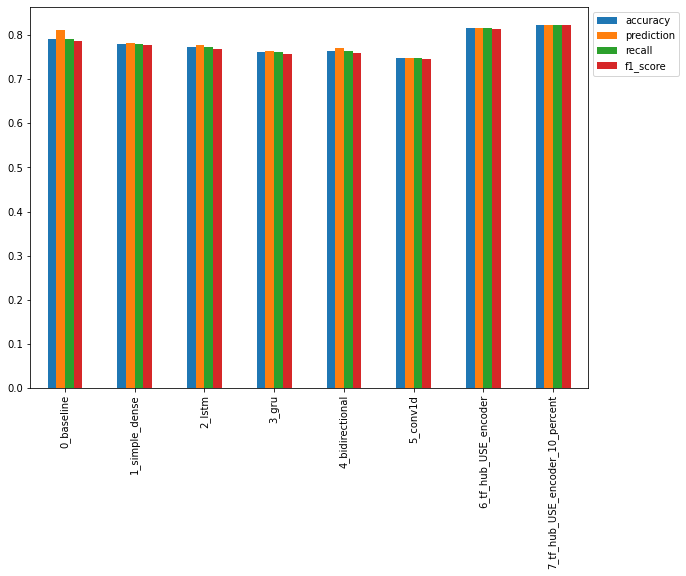

In [120]:
# plot and compare all of the model results
all_model_results.plot(kind="bar",
                       figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

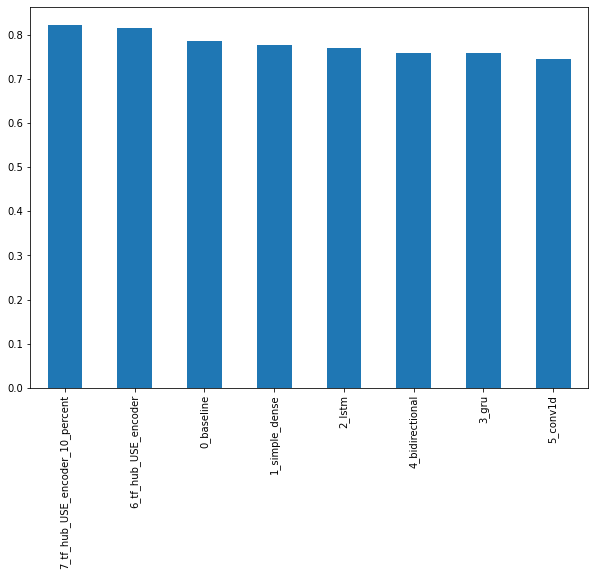

In [128]:
# sort model results by f1 score
all_model_results.sort_values("f1_score", ascending=False)["f1_score"].plot(kind="bar", figsize=(10,7));
# meaning: sort the model results according to f1_score in descending order, then extract the f1 column and plot a bar graph

In [129]:
! tensorboard dev

2023-03-08 00:28:41.140323: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-08 00:28:41.140558: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-08 00:28:41.140582: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2023-03-08 00:28:44.539653: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to c

## Uploading our model training logs to Tensorboard.dev
We can further inspect our performance using Tensorboard.dev

In [131]:
# upload tensorboard dev records

!tensorboard dev upload --logdir /content/model_logs \
--name "NLP Modelling Experiments ZTM TF Course" \
--description "Comparing multiple different types of model architectures on the Kaggle tweets text classification dataset" \
--one_shot # exit the upload once uploading is finished

2023-03-08 00:44:52.141429: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-08 00:44:52.141631: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-08 00:44:52.141669: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2023-03-08 00:44:54.270658: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to c

## Saving and loading a trained model
There are 2 formats to save a model in Tensorflow:
1. HDF5 format
2. The `savedmodel` format

In [132]:
# Save model to HDF5 format
model_6.save("model_6.h5")

In [134]:
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer":hub.KerasLayer})

In [135]:
model_6_results

{'accuracy': 81.62729658792651,
 'prediction': 0.8170007401548035,
 'recall': 0.8162729658792651,
 'f1_score': 0.8153469807013113}

In [136]:
# calculate_predictions_and_results(loaded_model_6)

24/24 [==============================] - 3s 21ms/step
[ True  True  True  True]


{'accuracy': 81.62729658792651,
 'prediction': 0.8170007401548035,
 'recall': 0.8162729658792651,
 'f1_score': 0.8153469807013113}

In [138]:
# Save TF Hub encoder to SavedModel format (default)
# model_6.save("model_6_Savedmodel_format")

In [139]:
loaded_model6_saved_model_format = tf.keras.models.load_model("model_6_Savedmodel_format")

In [140]:
calculate_predictions_and_results(loaded_model6_saved_model_format)

24/24 [==============================] - 1s 14ms/step
[ True  True  True  True]


{'accuracy': 81.62729658792651,
 'prediction': 0.8170007401548035,
 'recall': 0.8162729658792651,
 'f1_score': 0.8153469807013113}

In [141]:


from google.colab import files

In [143]:
files.download("/content/model_6_Savedmodel_format")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Finding the most wrong examples

* if our best model isn't perfect, what examples is it getting wrong?

* and of all these wrong examples, which is getting the most wrong?

for example if a sample should have a label of 0, but our model predicts 0.9999 (really close to 1) and vice versa

In [144]:
# Download a pretrained model from Google storage

In [145]:
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
unzip_data("08_model_6_USE_feature_extractor.zip")

--2023-03-08 01:26:31--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 108.177.12.128, 172.217.193.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M   124MB/s    in 7.2s    

2023-03-08 01:26:38 (126 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]



In [146]:
model_6_pretrained = tf.keras.models.load_model("/content/08_model_6_USE_feature_extractor")

In [147]:
calculate_predictions_and_results(model_6_pretrained)

24/24 [==============================] - 1s 12ms/step
[ True  True  True  True]


{'accuracy': 81.62729658792651,
 'prediction': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1_score': 0.8148082644367335}

In [151]:
model_6_pretrained_preds_probs = tf.squeeze(model_6_pretrained.predict(val_sentences))

model_6_pretrained_preds=tf.round(model_6_pretrained_preds_probs)


24/24 [==============================] - 1s 21ms/step


In [152]:
# Create DataFrame with validation sentences
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": model_6_pretrained_preds_probs})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [155]:
len(val_df)

762

In [176]:
# find the wrong predictions and sort by predition probabilities
most_wrong = val_df[val_df.pred != val_df.target].sort_values("pred_prob", ascending=False)
most_wrong.head(20) # false positives

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835455
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [175]:
most_wrong.tail(20) # false negatives

,text,target,pred,pred_prob
535,Rand Paul's Debate Strategy 'demolish Some oth...,1,0.0,0.098877
198,Perspectives on the Grateful Dead: Critical Wr...,1,0.0,0.094571
127,Petition | Heartless owner that whipped horse ...,1,0.0,0.093697
306,@Zak_Bagans this is Sabrina my dad rescued her...,1,0.0,0.092346
192,New post from @darkreading http://t.co/8eIJDXA...,1,0.0,0.082527
486,VICTORINOX SWISS ARMY DATE WOMEN'S RUBBER MOP ...,1,0.0,0.080427
361,Next May I'll be free...from school from oblig...,1,0.0,0.078982
40,@BoyInAHorsemask its a panda trapped in a dogs...,1,0.0,0.071388
352,@reriellechan HE WAS THE LICH KING'S FIRST CAS...,1,0.0,0.071257
681,'The way you move is like a full on rainstorm ...,1,0.0,0.069671


In [179]:
# Checking the false positives...
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n--------\n")

Target: 0, Pred: 1.0, Prob: 0.9101957082748413
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying
--------

Target: 0, Pred: 1.0, Prob: 0.8769820332527161
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J
--------

Target: 0, Pred: 1.0, Prob: 0.8523001670837402
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.
--------

Target: 0, Pred: 1.0, Prob: 0.835454523563385
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0
--------

Target: 0, Pred: 1.0, Prob: 0.8272131681442261
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.
--------

Target: 0, Pred: 1.0, Prob: 0.8148159384727478
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around 

In [180]:
# Checking the false negatives...

for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n--------\n")

Target: 1, Pred: 0.0, Prob: 0.06730345636606216
Text:
@DavidVonderhaar At least you were sincere ??
--------

Target: 1, Pred: 0.0, Prob: 0.05507584661245346
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu
--------

Target: 1, Pred: 0.0, Prob: 0.05460338667035103
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets
--------

Target: 1, Pred: 0.0, Prob: 0.054596997797489166
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy
--------

Target: 1, Pred: 0.0, Prob: 0.04963729530572891
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.
--------

Target: 1, Pred: 0.0, Prob: 0.04391849786043167
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren
--------

Target: 1, Pr

## Making predictions on the Test Dataset

In [181]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [184]:
type(val_sentences)

numpy.ndarray

In [186]:
test_sentences = test_df["text"].to_numpy()
test_sentences[:10]

array(['Just happened a terrible car crash',
       'Heard about #earthquake is different cities, stay safe everyone.',
       'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all',
       'Apocalypse lighting. #Spokane #wildfires',
       'Typhoon Soudelor kills 28 in China and Taiwan',
       "We're shaking...It's an earthquake",
       "They'd probably still show more life than Arsenal did yesterday, eh? EH?",
       'Hey! How are you?', 'What a nice hat?', 'Fuck off!'], dtype=object)

In [188]:
test_pred_probs = model_6_pretrained.predict(test_sentences)

102/102 [==============================] - 3s 25ms/step


In [189]:
test_pred_probs.shape

(3263, 1)

In [190]:
test_pred_probs[:5]

array([[0.51997006],
       [0.8752513 ],
       [0.82783276],
       [0.9335066 ],
       [0.9679583 ]], dtype=float32)

In [191]:
test_pred_probs=tf.squeeze(test_pred_probs)
test_preds = tf.round(test_pred_probs)
test_pd = pd.DataFrame({"text":test_sentences,
                        "target_predicted": test_preds,
                        "predict_probabilities": test_pred_probs})

In [192]:
test_pd.head()


,text,target_predicted,predict_probabilities
0,Just happened a terrible car crash,1.0,0.519970
1,"Heard about #earthquake is different cities, s...",1.0,0.875251
2,"there is a forest fire at spot pond, geese are...",1.0,0.827833
3,Apocalypse lighting. #Spokane #wildfires,1.0,0.933507
4,Typhoon Soudelor kills 28 in China and Taiwan,1.0,0.967958


In [199]:
test_pd[test_pd["target_predicted"]==1]

,text,target_predicted,predict_probabilities
0,Just happened a terrible car crash,1.0,0.519970
1,"Heard about #earthquake is different cities, s...",1.0,0.875251
2,"there is a forest fire at spot pond, geese are...",1.0,0.827833
3,Apocalypse lighting. #Spokane #wildfires,1.0,0.933507
4,Typhoon Soudelor kills 28 in China and Taiwan,1.0,0.967958
...,...,...,...
3258,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,1.0,0.800561
3259,Storm in RI worse than last hurricane. My city...,1.0,0.967862
3260,Green Line derailment in Chicago http://t.co/U...,1.0,0.915813
3261,MEG issues Hazardous Weather Outlook (HWO) htt...,1.0,0.517644


### Visualizing predictions (mrdbourke)

In [219]:
# Visualizing predictions 
sample_test = random.sample(range(len(test_pd)),5)
for sample in sample_test:
  print(f"\nPred:  {test_pd.loc[sample].target_predicted} \t Probability: {test_pd.loc[sample].predict_probabilities} \n")
  print(f"Text: {test_pd.loc[sample].text} \n\n------\n")


Pred:  0.0 	 Probability: 0.07622113823890686 

Text: Buying MoP http://t.co/tl7o6Zsqzy 

------


Pred:  0.0 	 Probability: 0.13960231840610504 

Text: Career goals ?? try not to cause a suicide bombing or raise psychos that like blowing shit up! 

------


Pred:  0.0 	 Probability: 0.016457220539450645 

Text: @_Gags_ My Mommy will be devastated lol #NoMorePod 

------


Pred:  0.0 	 Probability: 0.15127578377723694 

Text: World of Warcraft: Legion Revealed at gamescom: The Burning Legion returns to bring destruction to Azeroth onc... http://t.co/7n9qqkQIl3 

------


Pred:  0.0 	 Probability: 0.14623834192752838 

Text: Gonna throw a huge party and play nothing but Sandstorm. 

------



In [214]:
test_pd.iloc[2].text

'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all'

In [227]:
model_6_pretrained.predict(["911"])

1/1 [==============================] - 0s 115ms/step


array([[0.5614545]], dtype=float32)

# The speed/score tradeoff

In [228]:
# let's make a function to measure the time of prediction
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples
  """
  start_time = time.perf_counter()
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = end_time - start_time
  time_per_predictions = total_time/len(samples)
  return total_time, time_per_predictions 

In [230]:
# Calculate TF Hub Sentence encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6_pretrained, samples=val_sentences)

24/24 [==============================] - 1s 31ms/step


In [231]:
model_6_total_pred_time, model_6_time_per_pred

(1.4392395400027453, 0.0018887658005285373)

In [232]:
# Calculate our baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, samples=val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.1605582870033686, 0.0002107064133902475)

In [233]:
model_6_pretrained_results = calculate_predictions_and_results(model_6_pretrained)

24/24 [==============================] - 1s 28ms/step
[ True  True  True  True]


In [234]:
import matplotlib.pyplot as plt

(0.7, 0.9)

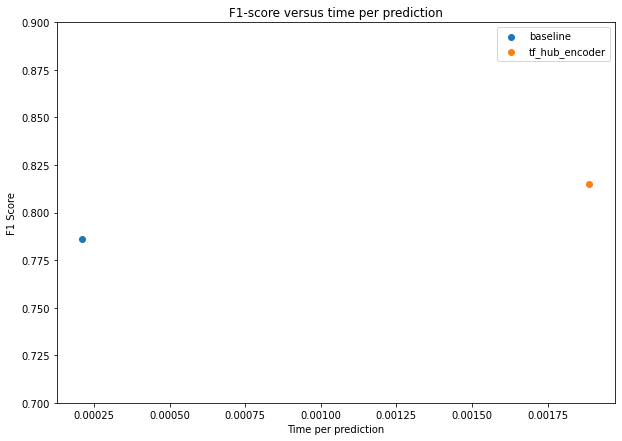

In [240]:
plt.figure(figsize=(10,7))
plt.scatter(baseline_time_per_pred, baseline_results["f1_score"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1_score"], label="tf_hub_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1 Score")
plt.ylim(0.7,0.9)

* Question - was the improvement in performance worth the loss in time???